In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Split Data Train & Test

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

train = pd.read_csv(r'train_after_selection.csv')

X = train.drop(['Response', 'Unnamed: 0'], axis=1)
y = train['Response']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [2]:
train.sample()

,Unnamed: 0,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Age_Bin,Vehicle_Damage_Age_Interaction,Response
20349,20349,1,28.0,0,0,1,152.0,1,1,0


In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63217 entries, 19573 to 15795
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Driving_License                 63217 non-null  int64  
 1   Region_Code                     63217 non-null  float64
 2   Previously_Insured              63217 non-null  int64  
 3   Vehicle_Age                     63217 non-null  int64  
 4   Vehicle_Damage                  63217 non-null  int64  
 5   Policy_Sales_Channel            63217 non-null  float64
 6   Age_Bin                         63217 non-null  int64  
 7   Vehicle_Damage_Age_Interaction  63217 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 4.3 MB


In [4]:
train.Response.value_counts()

Response
0    45155
1    45155
Name: count, dtype: int64

# Model Evaluasi 

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)

    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

    print("roc-auc (Test Proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (Train Proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))

    # StratifiedKFold for cross-validation with stratified sampling
    n_splits = 5
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform cross-validation
    cv_test_results = cross_validate(model, X_test, y_test, scoring=['roc_auc'],
                                cv=cv, return_train_score=False)
    cv_train_results = cross_validate(model, X_train, y_train, scoring=['roc_auc'],
                                cv=cv, return_train_score=False)

    # Display cross-validation results
    print(" ")
    print("Metrics Using Cross Validation:")
    print(f"Mean ROC-AUC (Test): {cv_test_results['test_roc_auc'].mean():.2f}")
    print(f"Std ROC-AUC (Test): {cv_test_results['test_roc_auc'].std():.2f}")
    print()
    print(f"Mean ROC-AUC (Train): {cv_train_results['test_roc_auc'].mean():.2f}")
    print(f"Std ROC-AUC (Train): {cv_train_results['test_roc_auc'].std():.2f}")

# Fit Model

In [7]:
logreg_model=LogisticRegression(solver='liblinear')
logreg_model.fit(X_train, y_train)
train_preds=logreg_model.predict(X_test)
accuracy_score(y_test, train_preds)

0.7838556084597498

In [8]:
from sklearn.linear_model import LogisticRegression # import logistic regression dari sklearn
logreg = LogisticRegression(solver= 'liblinear') # inisiasi object dengan nama logreg
logreg.fit(X_train, y_train) # fit model regression dari data train
eval_classification(logreg)

Accuracy (Test Set): 0.78
Precision (Test Set): 0.70
Recall (Test Set): 0.98
F1-Score (Test Set): 0.82
roc-auc (Test Proba): 0.81
roc_auc (Train Proba): 0.82
 
Metrics Using Cross Validation:
Mean ROC-AUC (Test): 0.81
Std ROC-AUC (Test): 0.01

Mean ROC-AUC (Train): 0.82
Std ROC-AUC (Train): 0.00


# Hyperparameter Tuning

## Metode RandomizedSearchCV

In [9]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

penalty = ['l1', 'l2']
C = [float(x) for x in np.linspace(0.0001, 0.002, 100)]
hyperparameters = dict(penalty=penalty, C=C)

logreg = LogisticRegression(solver= 'liblinear')
rs = RandomizedSearchCV(logreg, hyperparameters, scoring='roc_auc', random_state=1, cv=5, n_iter=50)
rs.fit(X_train, y_train)
eval_classification(rs)

Accuracy (Test Set): 0.78
Precision (Test Set): 0.70
Recall (Test Set): 0.98
F1-Score (Test Set): 0.82
roc-auc (Test Proba): 0.81
roc_auc (Train Proba): 0.82
 
Metrics Using Cross Validation:
Mean ROC-AUC (Test): 0.81
Std ROC-AUC (Test): 0.01

Mean ROC-AUC (Train): 0.82
Std ROC-AUC (Train): 0.00


In [27]:
def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [28]:
show_best_hyperparameter(rs)

{'C': 0.002, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


# Learning Curve

In [25]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for c in param_values:
        model = LogisticRegression(penalty='l2', C=c)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.xlabel('C')
    plt.ylabel('AUC')
    plt.title('Learning Curve - Hyperparameter C - Logistic Regression')
    plt.legend()
    plt.show()

param value: 0.001; train: 0.8137440754973296; test: 0.8095723654095153
param value: 0.00101010101010101; train: 0.8137411908850536; test: 0.8095914384800835
param value: 0.0010202020202020202; train: 0.8138520803054037; test: 0.8096698560473623
param value: 0.0010303030303030303; train: 0.8140436597978764; test: 0.8099054030194306
param value: 0.0010404040404040403; train: 0.813780077100021; test: 0.8096004954638788
param value: 0.0010505050505050504; train: 0.813746636816835; test: 0.80960049001443
param value: 0.0010606060606060607; train: 0.813768980050644; test: 0.8096244185438201
param value: 0.0010707070707070708; train: 0.8137895106429431; test: 0.8095974165253441
param value: 0.0010808080808080809; train: 0.8138638069249131; test: 0.8096894032199702
param value: 0.001090909090909091; train: 0.8137854579728857; test: 0.8096179827448655
param value: 0.001101010101010101; train: 0.8137873286669676; test: 0.8096333665386409
param value: 0.0011111111111111111; train: 0.813775684121

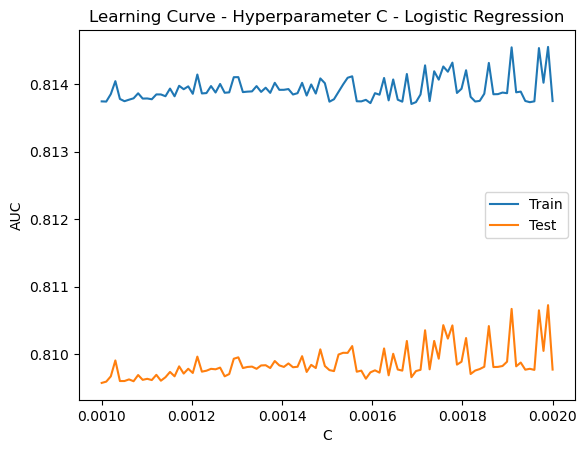

In [26]:
# learning curve
import numpy as np
param_values = [float(x) for x in np.linspace(0.001, 0.002, 100)]
draw_learning_curve(param_values)

# Confussion Matrix

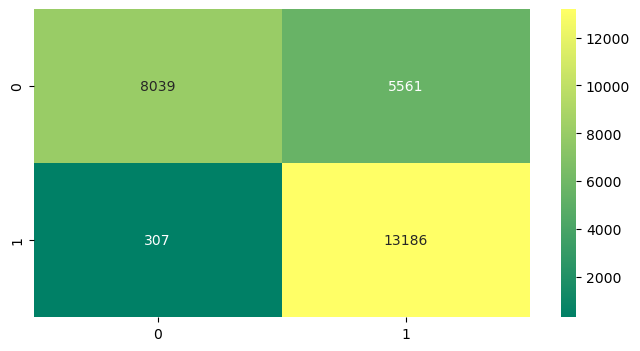

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

logreg = LogisticRegression(solver= 'lbfgs') # inisiasi object dengan nama logreg
logreg.fit(X_train, y_train)

# Misalkan y_pred adalah hasil prediksi model pada data uji
y_pred = logreg.predict(X_test)

# Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualisasikan confusion matrix
plt.figure(figsize=(8, 4))
sns.heatmap(cm, annot=True, fmt="g", cmap="summer")
plt.show()


# Feature Importance

<Axes: ylabel='Feature'>

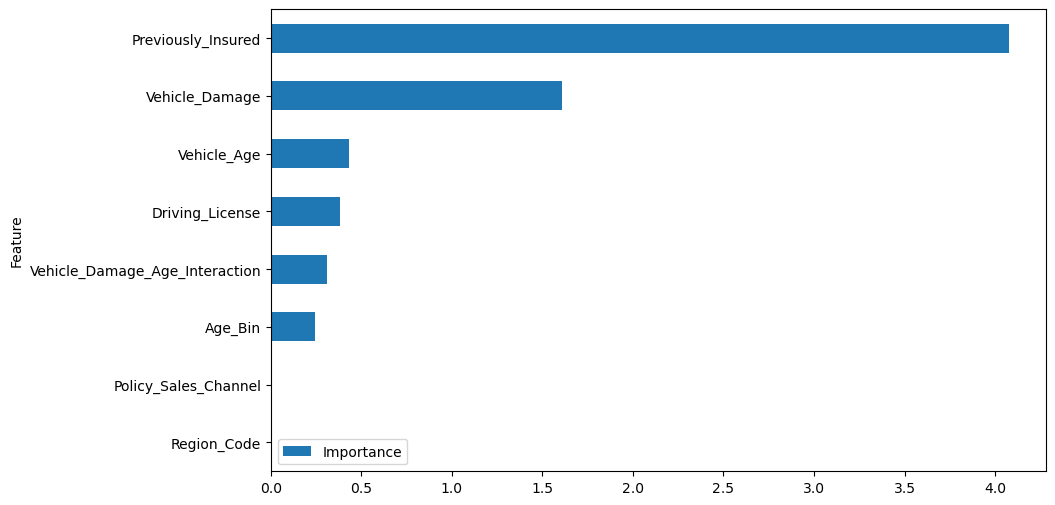

In [20]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)


coefficients = logreg.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))